In [2]:
!pip install google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client
from google.colab import auth
auth.authenticate_user()
import gspread
from google.auth import default
creds, _ = default() # get_application_default() is deprecated

gc = gspread.authorize(creds) # gspread now expects google-auth credentials
# Taken from last year's notebook

!pip install ISLP

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.0/350.0 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=f53245d1042755aa8cc6093c841b33bf3cf68fec444d502c2bd1bb4bfd0bc7c4
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [3]:
import seaborn as sns
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import re


In [4]:
from sklearn.cluster import \
     (KMeans,
      AgglomerativeClustering)
from scipy.spatial.distance import pdist, squareform
from ISLP.cluster import compute_linkage
from scipy.cluster.hierarchy import \
     (dendrogram,
      cut_tree,
      linkage)


In [5]:
pip install gower

In [6]:
import gower

In [7]:
# import data from google survey

# real one
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1IxP1wH9CJMFxqZI-ZSt8q-EcQtlF5mnP-btR4SKDWV4/edit?gid=804837988#gid=804837988')

# simulated
# wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1fiIOkwfttAIv5P0ca6IcVdAk5IAG-WrThyriQiXPRIQ/edit?gid=1707814890#gid=1707814890')

sheet = wb.sheet1

In [8]:
# clean up data form/design matrix
data = sheet.get_all_values()
df_unclean = pd.DataFrame(data)
df_unclean = df_unclean.iloc[:,1:]
questions = ["How fast do you prefer to move through material?",
             "How much help do you expect from a study group?",
             "What days are you available to meet for your study group?",
             "What is your ideal study session length?",
             "What is your preferred meeting format?",
             "I learn best when someone...",
             "Rate your comfort in asking questions on a scale of 1-5.",
             "Choose what study group you prefer.",
             "What is your preference when prepping for exams?"]
column_names = ["speed", "need", "avail_day", "session_len", "pref_format", "learn", "comfort", "group_type", "exam_prep"]
df_unclean.columns = df_unclean.iloc[0]
df = df_unclean.loc[:,questions]
df_unclean = df_unclean.iloc[1:]
df.columns = column_names
df = df.iloc[1:]
df.head()

,speed,need,avail_day,session_len,pref_format,learn,comfort,group_type,exam_prep
1,4,4,"Mondays, Wednesdays, Thursdays",90 min,Discord,shows worked examples,4,Balanced (Work + Quick Breaks),"""Teach-Back"" Sessions"
2,2,2,"Mondays, Fridays, Saturdays, Sundays",60 min,In-Person,shows worked examples,3,Balanced (Work + Quick Breaks),Mixed
3,4,3,"Fridays, Saturdays",30 - 45min,In-Person,asks me guiding questions,5,Social + Collaborative,Practice Exams Together
4,2,3,"Mondays, Wednesdays, Fridays",60 min,In-Person,"lets me try first, then helps fix mistakes",4,Balanced (Work + Quick Breaks),Flashcards/Definitions


In [9]:
df.columns


Index(['speed', 'need', 'avail_day', 'session_len', 'pref_format', 'learn',
       'comfort', 'group_type', 'exam_prep'],
      dtype='object')

In [10]:
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
for day in days:
  avail = [(day in example) for example in df['avail_day'].values]
  df[day] = (avail)

In [11]:
df = df.drop(columns='avail_day')
df.head()

,speed,need,session_len,pref_format,learn,comfort,group_type,exam_prep,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
1,4,4,90 min,Discord,shows worked examples,4,Balanced (Work + Quick Breaks),"""Teach-Back"" Sessions",False,True,False,True,True,False,False
2,2,2,60 min,In-Person,shows worked examples,3,Balanced (Work + Quick Breaks),Mixed,True,True,False,False,False,True,True
3,4,3,30 - 45min,In-Person,asks me guiding questions,5,Social + Collaborative,Practice Exams Together,False,False,False,False,False,True,True
4,2,3,60 min,In-Person,"lets me try first, then helps fix mistakes",4,Balanced (Work + Quick Breaks),Flashcards/Definitions,False,True,False,True,False,True,False


In [12]:
df.dtypes

,0
speed,object
need,object
session_len,object
pref_format,object
learn,object
comfort,object
group_type,object
exam_prep,object
Sunday,bool
Monday,bool


In [13]:
df.comfort = df.comfort.astype(int)
df.speed = df.speed.astype(int)
df.need = df.need.astype(int)
df.dtypes

,0
speed,int64
need,int64
session_len,object
pref_format,object
learn,object
comfort,int64
group_type,object
exam_prep,object
Sunday,bool
Monday,bool


In [14]:
# define feature weights
weights = np.array([1, 1.6, 1, 1.1, 1, 0.7, 1.4, 1.2, (2/7), (2/7), (2/7), (2/7), (2/7), (2/7), (2/7)])

# Distance Method: Gower's Distance

We chose Gower’s distance because we assume the survey data will contain a mix of categorical and numeric variables. Gower’s distance is a highly effective measure of distance for mixed data types, since it is designed to measure dissimilarity between observations, whereas other metrics such as Euclidian cannot handle dissimilarity between different data types numerically. The resulting distances in Gower’s are normalized between 0 and 1, which makes it efficient and easy to interpret the results and compare across groups of students. Gower’s method also accounts for differences in scaling by standardizing numeric variables by their range, eliminating the need for extra steps in scaling.

Another reason we chose Gower’s was due to its flexibility, different variables can be weighted according to their importance, allowing us to focus on and emphasize factors that are most important for study group compatibility. Gower’s also handles missing data by computing distances using only the available variables for all students.


In [15]:
categoricals = np.array([False, False, True, True, True, False, True, True, True, True, True, True, True, True, True])

In [16]:
# create distance matrix
dist = gower.gower_matrix(df, weight=weights, cat_features=categoricals).round(2)

dist = pd.DataFrame(dist,
                       index=df.index,
                       columns=df.index).round(2)

dist

,1,2,3,4
1,0.00,0.70,0.75,0.61
2,0.70,0.00,0.70,0.38
3,0.75,0.70,0.00,0.62
4,0.61,0.38,0.62,0.00


# Linkage Type: Complete Linkage
The goal with our clusters is to create small, tight-knit clusters of students. As such we chose against single linkage to avoid possible cluster chains which group together lengths of objects rather than what we want. Another issue with single linkage is that it tends to cover a wider area, allowing a wider range of objects in. Centroid linkage on the other hand relies greatly on numeric data to calculate distances which makes it ill suited for our purposes given that the majority of our data will be categorical. Lastly, between average and complete linkage we use complete linkage due to its propensity toward tight clusters. One of our primary concerns is controlling cluster sizes, and while complete linkage is susceptible to outliers, its ability to cluster small groups together give it an edge for our purposes.

In complete linkage, we calculate the distance between every single point in every single cluster. Then we find the largest possible distances in between clusters. Then from that list of largest distances, we merge the clusters that have the smallest distance.

![Complete-Linkage.jpg](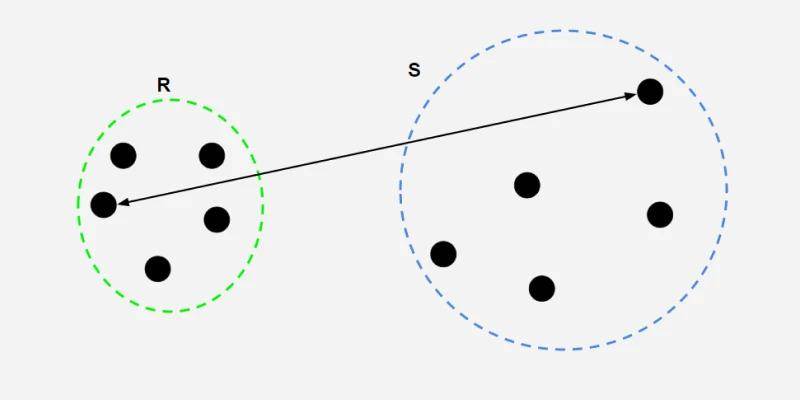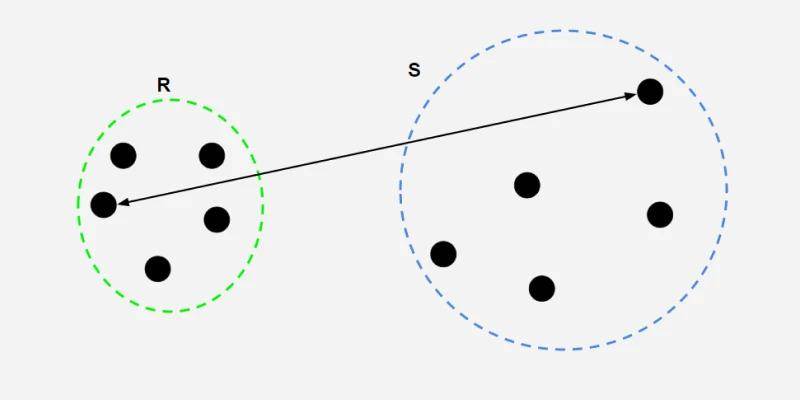)

# N_Clusters = 18
We recommend a cluster size between 17 and 19, which will hopefully result in smaller study groups. Choosing a study group size is subjective, but we are of the opinion that a study group of at least 4 will result in a sufficient variation in knowledge and capability, and a group larger than 5 will greatly increase the risk of distraction, reducing study time and efficacy.

# A Major Limitation:

We are using a function from the scipy python library that compares student distances and pairs students based on complete linkage. A major issue with using this pre-made function is that we cannot guarrentee the sizes of clusters. Some clusters of students can have 5+ students, while other clusters can have 1 student. Due to time constraints, we continue to use these functions and will advise work arounds to ensure proper study group sizes.

One work around is through n_clusters. We recommend n_clusters = 18 for study groups of 4 to 5 students, but the function will not ensure this is the case. If clusters exceed 5 students, then increasing n_clusters may prevent larger clusters from being formed. BUT if n_clusters is too high, cluster sizes will be too small. This is a balancing act and may take a couple repetitions of running the code to produce a suitable result.

In [17]:
# cut dendrogram

"""
  Following 'clusters' sets the number of clusters. We advise n_clusters = 18 to start.

  Further down will be a cell that returns the number of students in each cluster.
  Due to how cut_tree works we can not guarrentee clusters within certain size
  limitations. Because of this you may need to alter n_clusters to suit your data.
  Specifically, if cluster sizes exceed 5 you may need to increase n_clusters by 1.

  Clusters with only 1-2 student should be advised to join another group to form
  clusters of appropriate size (3-5 students ideally).
"""
link_complete = linkage(dist, 'complete')
clusters = cut_tree(link_complete, n_clusters=18).flatten()
clusters

/tmp/ipython-input-1519693715.py:14: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link_complete = linkage(dist, 'complete')


array([0, 1, 2, 3])

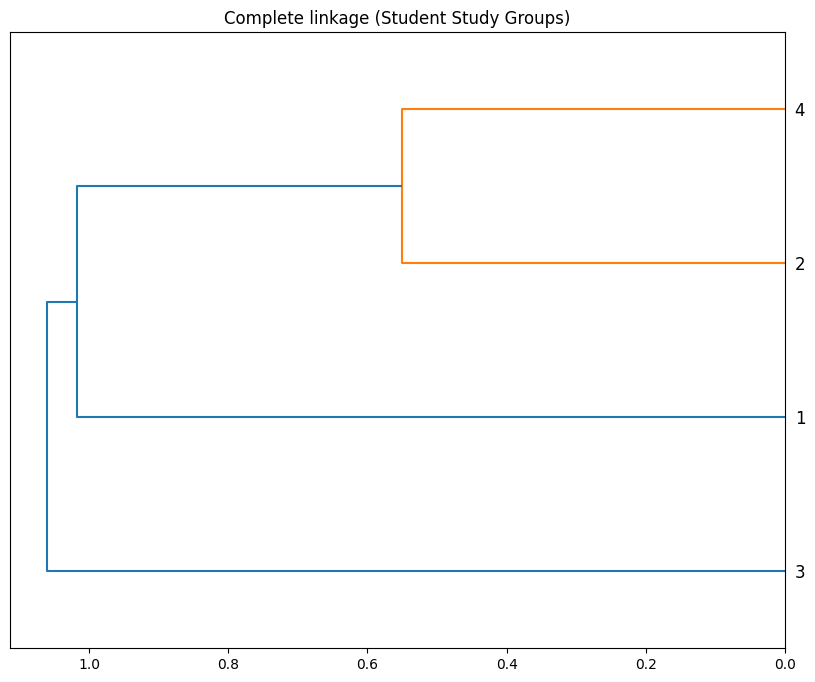

In [18]:
# and this one we visually show the cluster diffs



fig, ax = plt.subplots(figsize=(10,8))
dendrogram(link_complete, labels=df.index, ax=ax, orientation= 'left')
ax.set_title('Complete linkage (Student Study Groups)')
plt.show()

In [19]:
# table

"""
Here we see the number of students in each cluster.

Adjust n_clusters above as needed to create clusters that do not exceed 5 students.

Students with only 1-2 students should be advised to join another group to form
clusters of appropriate size (ideally 3-5 students).
"""

df['clusters'] = clusters
df.groupby('clusters').size()

,0
clusters,
0,1
1,1
2,1
3,1


In [20]:
# This table shows each students cluster

df_groups = df_unclean.copy()
df_groups['group'] = clusters
usernames = df_groups['Email Address'].values
usernames = re.findall(r'(\w+)@', str(usernames))
df_groups['username'] = usernames
df_groups = df_groups.loc[:,['username', 'group']]
df_groups.groupby('group').agg(list)

,username
group,
0,[rta21]
1,[pgr12]
2,[jna45]
3,[ks612]
